**Install dependencies and download dataset**


In [ ]:
!pip install torchvision matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!wget https://archive.org/download/UTKFace/UTKFace.tar.gz
!mkdir -p utkface && tar -xvzf UTKFace.tar.gz -C utkface


Streaming output truncated to the last 5000 lines.
UTKFace/33_1_0_20170111182452825.jpg.chip.jpg
UTKFace/26_1_1_20170116024053194.jpg.chip.jpg
UTKFace/25_1_0_20170109213232182.jpg.chip.jpg
UTKFace/28_1_1_20170112234526480.jpg.chip.jpg
UTKFace/57_0_0_20170117191704100.jpg.chip.jpg
UTKFace/27_1_1_20170117193211345.jpg.chip.jpg
UTKFace/46_1_1_20170116161237892.jpg.chip.jpg
UTKFace/24_0_2_20170116171647508.jpg.chip.jpg
UTKFace/42_1_1_20170113005712902.jpg.chip.jpg
UTKFace/25_1_1_20170116001337504.jpg.chip.jpg
UTKFace/40_1_0_20170116222110661.jpg.chip.jpg
UTKFace/50_1_0_20170109012257664.jpg.chip.jpg
UTKFace/26_1_3_20170104235421282.jpg.chip.jpg
UTKFace/7_0_0_20170110215711115.jpg.chip.jpg
UTKFace/1_1_2_20161219155353413.jpg.chip.jpg
UTKFace/26_0_1_20170117195651493.jpg.chip.jpg
UTKFace/7_0_0_20170110215648859.jpg.chip.jpg
UTKFace/64_0_0_20170117155540137.jpg.chip.jpg
UTKFace/48_0_0_20170109004813150.jpg.chip.jpg
UTKFace/39_0_0_20170103183230555.jpg.chip.jpg
UTKFace/45_0_1_20170117190019363

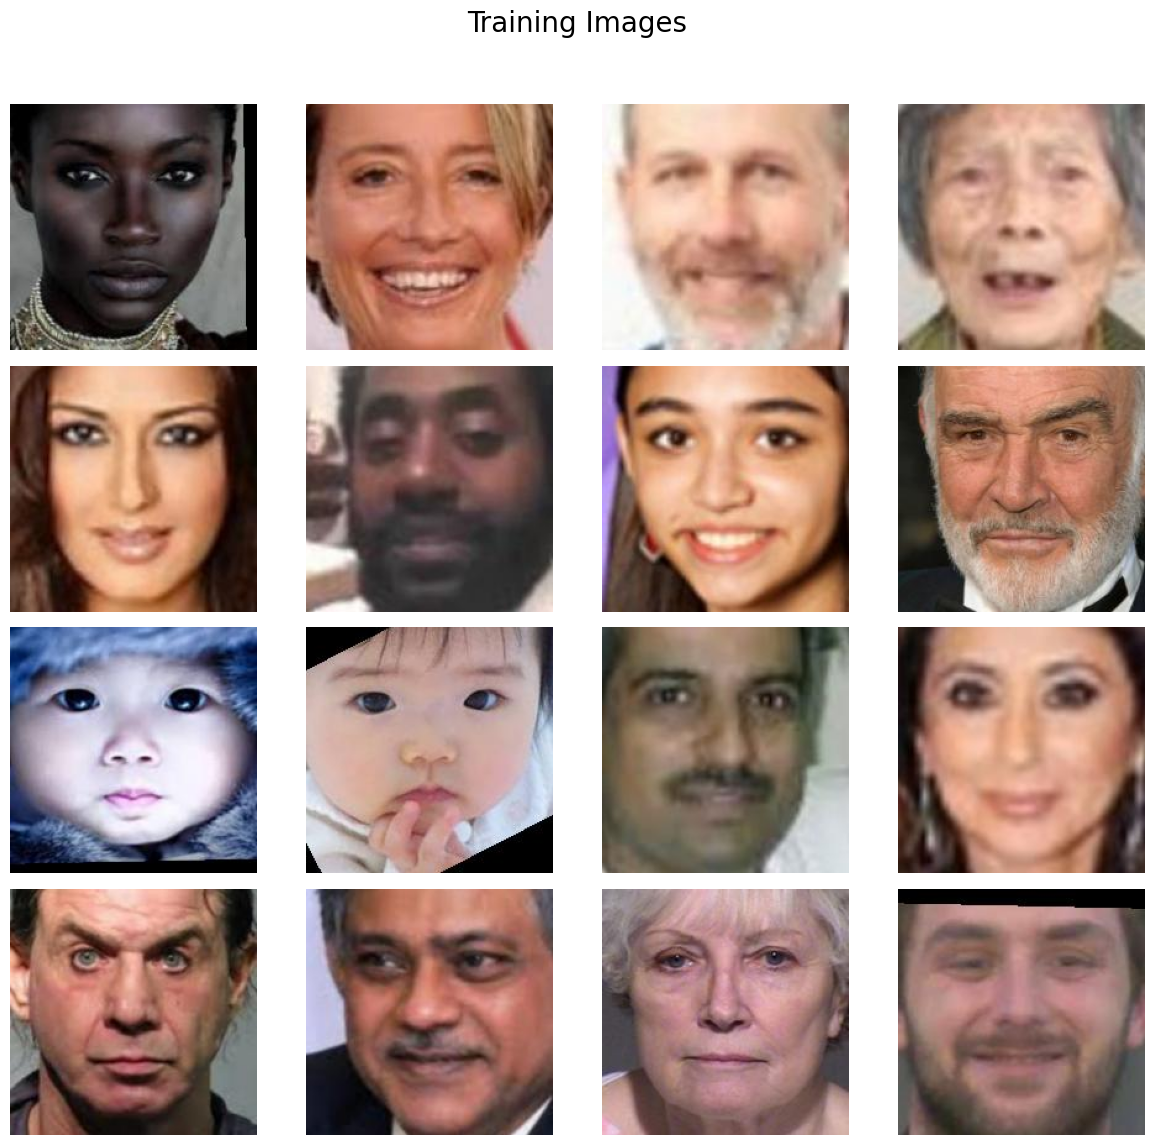

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set the directory where the images were extracted
image_dir = 'utkface/UTKFace'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Show the first 16 images
num_images = 16
plt.figure(figsize=(12, 12))
plt.suptitle("Training Images", fontsize=20)

for i in range(num_images):
    img_path = os.path.join(image_dir, image_files[i])
    img = mpimg.imread(img_path)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Process the dataset**



In [ ]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        age = int(img_name.split('_')[0])  # Extract age label from filename
        age_class = min(age // 10, 5)      # Bin ages into 6 groups (0-9, ..., 50+)

        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(age_class, dtype=torch.long)
        return image, label

dataset = UTKFaceDataset("utkface/UTKFace", transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)


**Define Generator and Discriminator**

In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim=100, label_dim=6, img_channels=3):
        super().__init__()
        self.label_embed = nn.Embedding(label_dim, label_dim)
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, img_channels * 64 * 64),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embed = self.label_embed(labels)
        x = torch.cat([noise, label_embed], dim=1)
        img = self.model(x)
        return img.view(x.size(0), 3, 64, 64)

class Discriminator(nn.Module):
    def __init__(self, label_dim=6, img_channels=3):
        super().__init__()
        self.label_embed = nn.Embedding(label_dim, label_dim)
        self.model = nn.Sequential(
            nn.Linear(img_channels * 64 * 64 + label_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, img, labels):
        label_embed = self.label_embed(labels)
        x = torch.cat([img.view(img.size(0), -1), label_embed], dim=1)
        return self.model(x)


**WGAN-GP Loss Functions**

In [ ]:
def gradient_penalty(D, real, fake, labels, device):
    alpha = torch.rand(real.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones_like(d_interpolates),
                                    create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp


**Training Loop with Visualization + Checkpoint**

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
G = Generator().to(device)
D = Discriminator().to(device)

optimizer_G = optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=1e-4, betas=(0.0, 0.9))

fixed_noise = torch.randn(6, 100, device=device)
fixed_labels = torch.tensor(list(range(6)), device=device)

def save_samples(generator, step):
    with torch.no_grad():
        samples = generator(fixed_noise, fixed_labels).cpu()
        grid = (samples + 1) / 2  # unnormalize
        fig, axes = plt.subplots(1, 6, figsize=(12, 2))
        for img, ax in zip(grid, axes):
            ax.imshow(img.permute(1, 2, 0).numpy())
            ax.axis("off")
        plt.savefig(f"generated_epoch_{step}.png")
        plt.close()

os.makedirs("checkpoints", exist_ok=True)

for epoch in range(1, 101):
    for i, (real_imgs, labels) in enumerate(tqdm(dataloader)):
        real_imgs, labels = real_imgs.to(device), labels.to(device)

        # --- Train Discriminator ---
        noise = torch.randn(real_imgs.size(0), 100, device=device)
        fake_imgs = G(noise, labels).detach()
        real_validity = D(real_imgs, labels)
        fake_validity = D(fake_imgs, labels)
        gp = gradient_penalty(D, real_imgs, fake_imgs, labels, device)

        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + 10 * gp
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        if i % 5 == 0:
            noise = torch.randn(real_imgs.size(0), 100, device=device)
            gen_imgs = G(noise, labels)
            g_loss = -torch.mean(D(gen_imgs, labels))

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

    print(f"[Epoch {epoch}] D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
    save_samples(G, epoch)
    torch.save(G.state_dict(), f"checkpoints/generator_epoch_{epoch}.pth")


  0%|          | 0/371 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 371/371 [00:26<00:00, 13.92it/s]


[Epoch 1] D Loss: -26.3130 | G Loss: -0.4768


100%|██████████| 371/371 [00:26<00:00, 14.18it/s]


[Epoch 2] D Loss: -11.8764 | G Loss: -2.3113


100%|██████████| 371/371 [00:25<00:00, 14.83it/s]


[Epoch 3] D Loss: -12.7076 | G Loss: 1.6063


100%|██████████| 371/371 [00:25<00:00, 14.68it/s]


[Epoch 4] D Loss: -10.3581 | G Loss: -2.2075


100%|██████████| 371/371 [00:25<00:00, 14.44it/s]


[Epoch 5] D Loss: -7.9295 | G Loss: -3.3338


100%|██████████| 371/371 [00:25<00:00, 14.59it/s]


[Epoch 6] D Loss: -7.5964 | G Loss: 2.9647


100%|██████████| 371/371 [00:25<00:00, 14.62it/s]


[Epoch 7] D Loss: -10.8667 | G Loss: -0.7535


100%|██████████| 371/371 [00:25<00:00, 14.79it/s]


[Epoch 8] D Loss: -8.1634 | G Loss: 2.4929


100%|██████████| 371/371 [00:25<00:00, 14.82it/s]


[Epoch 9] D Loss: -6.9136 | G Loss: -1.1981


100%|██████████| 371/371 [00:25<00:00, 14.77it/s]


[Epoch 10] D Loss: -3.3344 | G Loss: 3.1411


100%|██████████| 371/371 [00:25<00:00, 14.74it/s]


[Epoch 11] D Loss: -6.3552 | G Loss: 2.7637


100%|██████████| 371/371 [00:26<00:00, 14.19it/s]


[Epoch 12] D Loss: -5.5127 | G Loss: 0.5458


100%|██████████| 371/371 [00:26<00:00, 14.16it/s]


[Epoch 13] D Loss: -2.7335 | G Loss: -0.0166


100%|██████████| 371/371 [00:26<00:00, 13.93it/s]


[Epoch 14] D Loss: -2.7592 | G Loss: 4.1731


100%|██████████| 371/371 [00:26<00:00, 14.25it/s]


[Epoch 15] D Loss: -4.0017 | G Loss: 4.1547


100%|██████████| 371/371 [00:25<00:00, 14.71it/s]


[Epoch 16] D Loss: -4.9499 | G Loss: -1.4844


100%|██████████| 371/371 [00:24<00:00, 15.40it/s]


[Epoch 17] D Loss: -2.6566 | G Loss: -1.1188


100%|██████████| 371/371 [00:23<00:00, 15.57it/s]


[Epoch 18] D Loss: -2.0110 | G Loss: 4.4271


100%|██████████| 371/371 [00:24<00:00, 15.01it/s]


[Epoch 19] D Loss: -6.3804 | G Loss: 1.3359


100%|██████████| 371/371 [00:25<00:00, 14.78it/s]


[Epoch 20] D Loss: -3.5825 | G Loss: 2.2422


100%|██████████| 371/371 [00:25<00:00, 14.83it/s]


[Epoch 21] D Loss: -5.9326 | G Loss: 3.9603


100%|██████████| 371/371 [00:24<00:00, 14.91it/s]


[Epoch 22] D Loss: -2.7441 | G Loss: -0.5910


100%|██████████| 371/371 [00:24<00:00, 15.02it/s]


[Epoch 23] D Loss: -7.2734 | G Loss: 4.1679


100%|██████████| 371/371 [00:25<00:00, 14.72it/s]


[Epoch 24] D Loss: -6.3064 | G Loss: -3.7170


100%|██████████| 371/371 [00:25<00:00, 14.80it/s]


[Epoch 25] D Loss: -5.2392 | G Loss: -0.5552


100%|██████████| 371/371 [00:24<00:00, 14.85it/s]


[Epoch 26] D Loss: -2.1261 | G Loss: 1.4924


100%|██████████| 371/371 [00:25<00:00, 14.80it/s]


[Epoch 27] D Loss: -4.3121 | G Loss: -0.2883


100%|██████████| 371/371 [00:25<00:00, 14.61it/s]


[Epoch 28] D Loss: -5.7124 | G Loss: -2.5505


100%|██████████| 371/371 [00:24<00:00, 14.92it/s]


[Epoch 29] D Loss: -1.6610 | G Loss: 4.7500


100%|██████████| 371/371 [00:24<00:00, 14.92it/s]


[Epoch 30] D Loss: -6.2350 | G Loss: -0.3455


100%|██████████| 371/371 [00:24<00:00, 15.10it/s]


[Epoch 31] D Loss: -0.7024 | G Loss: -0.8984


100%|██████████| 371/371 [00:24<00:00, 15.19it/s]


[Epoch 32] D Loss: -5.4311 | G Loss: -1.2455


100%|██████████| 371/371 [00:23<00:00, 15.59it/s]


[Epoch 33] D Loss: -0.9246 | G Loss: 0.6474


100%|██████████| 371/371 [00:24<00:00, 15.12it/s]


[Epoch 34] D Loss: -5.2284 | G Loss: -2.8285


100%|██████████| 371/371 [00:24<00:00, 14.97it/s]


[Epoch 35] D Loss: -5.2961 | G Loss: 5.3785


100%|██████████| 371/371 [00:24<00:00, 15.03it/s]


[Epoch 36] D Loss: -2.4625 | G Loss: 2.2452


100%|██████████| 371/371 [00:24<00:00, 14.84it/s]


[Epoch 37] D Loss: -3.2270 | G Loss: 1.9670


100%|██████████| 371/371 [00:24<00:00, 14.84it/s]


[Epoch 38] D Loss: -0.6949 | G Loss: 3.1865


100%|██████████| 371/371 [00:24<00:00, 14.89it/s]


[Epoch 39] D Loss: -0.3806 | G Loss: 0.8477


100%|██████████| 371/371 [00:24<00:00, 14.92it/s]


[Epoch 40] D Loss: -0.3469 | G Loss: -1.6520


100%|██████████| 371/371 [00:24<00:00, 15.05it/s]


[Epoch 41] D Loss: 1.2775 | G Loss: 1.9901


100%|██████████| 371/371 [00:24<00:00, 15.02it/s]


[Epoch 42] D Loss: -1.2353 | G Loss: 4.3812


100%|██████████| 371/371 [00:24<00:00, 14.91it/s]


[Epoch 43] D Loss: -5.3429 | G Loss: 3.7332


100%|██████████| 371/371 [00:24<00:00, 15.08it/s]


[Epoch 44] D Loss: 0.4480 | G Loss: 0.5681


100%|██████████| 371/371 [00:24<00:00, 15.32it/s]


[Epoch 45] D Loss: -0.3675 | G Loss: -0.0765


100%|██████████| 371/371 [00:24<00:00, 15.22it/s]


[Epoch 46] D Loss: 3.8091 | G Loss: -1.8629


100%|██████████| 371/371 [00:25<00:00, 14.61it/s]


[Epoch 47] D Loss: -2.3328 | G Loss: -3.3390


100%|██████████| 371/371 [00:24<00:00, 14.92it/s]


[Epoch 48] D Loss: -2.5044 | G Loss: -0.0668


100%|██████████| 371/371 [00:24<00:00, 15.06it/s]


[Epoch 49] D Loss: -2.1958 | G Loss: 5.2992


100%|██████████| 371/371 [00:24<00:00, 15.01it/s]


[Epoch 50] D Loss: 0.6460 | G Loss: -2.0863


100%|██████████| 371/371 [00:24<00:00, 14.88it/s]


[Epoch 51] D Loss: -1.2830 | G Loss: -0.4003


100%|██████████| 371/371 [00:25<00:00, 14.83it/s]


[Epoch 52] D Loss: -2.3730 | G Loss: 0.7714


100%|██████████| 371/371 [00:24<00:00, 14.94it/s]


[Epoch 53] D Loss: -1.6874 | G Loss: 4.8343


100%|██████████| 371/371 [00:25<00:00, 14.72it/s]


[Epoch 54] D Loss: -2.6258 | G Loss: 0.8335


100%|██████████| 371/371 [00:24<00:00, 14.86it/s]


[Epoch 55] D Loss: -4.3639 | G Loss: 1.4840


100%|██████████| 371/371 [00:25<00:00, 14.77it/s]


[Epoch 56] D Loss: -3.8766 | G Loss: -0.9908


100%|██████████| 371/371 [00:24<00:00, 14.99it/s]


[Epoch 57] D Loss: -0.2400 | G Loss: 1.7482


100%|██████████| 371/371 [00:24<00:00, 15.19it/s]


[Epoch 58] D Loss: -0.2891 | G Loss: 0.3380


100%|██████████| 371/371 [00:24<00:00, 15.38it/s]


[Epoch 59] D Loss: -3.6045 | G Loss: -2.2127


100%|██████████| 371/371 [00:24<00:00, 15.23it/s]


[Epoch 60] D Loss: -0.4038 | G Loss: -2.0315


100%|██████████| 371/371 [00:24<00:00, 14.88it/s]


[Epoch 61] D Loss: -2.9747 | G Loss: 1.7445


100%|██████████| 371/371 [00:25<00:00, 14.80it/s]


[Epoch 62] D Loss: -0.4328 | G Loss: -0.5445


100%|██████████| 371/371 [00:25<00:00, 14.63it/s]


[Epoch 63] D Loss: -2.4807 | G Loss: 0.3301


100%|██████████| 371/371 [00:24<00:00, 14.89it/s]


[Epoch 64] D Loss: -3.1145 | G Loss: 1.9402


100%|██████████| 371/371 [00:25<00:00, 14.83it/s]


[Epoch 65] D Loss: -1.6998 | G Loss: 1.5401


100%|██████████| 371/371 [00:24<00:00, 14.99it/s]


[Epoch 66] D Loss: -0.7505 | G Loss: 1.6930


100%|██████████| 371/371 [00:24<00:00, 15.15it/s]


[Epoch 67] D Loss: -2.7902 | G Loss: 2.3564


100%|██████████| 371/371 [00:24<00:00, 14.97it/s]


[Epoch 68] D Loss: -0.7066 | G Loss: -2.1855


100%|██████████| 371/371 [00:24<00:00, 15.06it/s]


[Epoch 69] D Loss: -1.6749 | G Loss: -1.2219


100%|██████████| 371/371 [00:24<00:00, 15.24it/s]


[Epoch 70] D Loss: -2.4251 | G Loss: 0.8018


100%|██████████| 371/371 [00:24<00:00, 15.41it/s]


[Epoch 71] D Loss: -5.1996 | G Loss: -2.0493


100%|██████████| 371/371 [00:24<00:00, 15.14it/s]


[Epoch 72] D Loss: -2.0477 | G Loss: -1.1710


100%|██████████| 371/371 [00:25<00:00, 14.71it/s]


[Epoch 73] D Loss: -1.6458 | G Loss: 1.3749


100%|██████████| 371/371 [00:24<00:00, 15.01it/s]


[Epoch 74] D Loss: -0.6206 | G Loss: -0.6700


100%|██████████| 371/371 [00:25<00:00, 14.80it/s]


[Epoch 75] D Loss: -2.5172 | G Loss: 2.3608


100%|██████████| 371/371 [00:24<00:00, 14.91it/s]


[Epoch 76] D Loss: -0.0802 | G Loss: 0.4498


100%|██████████| 371/371 [00:24<00:00, 15.08it/s]


[Epoch 77] D Loss: -3.1319 | G Loss: 2.5953


100%|██████████| 371/371 [00:24<00:00, 15.04it/s]


[Epoch 78] D Loss: -4.7130 | G Loss: 1.2147


100%|██████████| 371/371 [00:25<00:00, 14.63it/s]


[Epoch 79] D Loss: -1.5629 | G Loss: 1.3909


100%|██████████| 371/371 [00:25<00:00, 14.70it/s]


[Epoch 80] D Loss: -1.7522 | G Loss: 5.2802


100%|██████████| 371/371 [00:24<00:00, 14.88it/s]


[Epoch 81] D Loss: -1.1554 | G Loss: -6.0437


100%|██████████| 371/371 [00:25<00:00, 14.64it/s]


[Epoch 82] D Loss: -0.8866 | G Loss: 3.7247


100%|██████████| 371/371 [00:24<00:00, 14.94it/s]


[Epoch 83] D Loss: -1.7950 | G Loss: -0.9030


100%|██████████| 371/371 [00:24<00:00, 15.34it/s]


[Epoch 84] D Loss: -2.6725 | G Loss: -0.4193


100%|██████████| 371/371 [00:24<00:00, 14.90it/s]


[Epoch 85] D Loss: -2.4232 | G Loss: -0.8839


100%|██████████| 371/371 [00:25<00:00, 14.78it/s]


[Epoch 86] D Loss: -2.1618 | G Loss: -2.3736


100%|██████████| 371/371 [00:25<00:00, 14.77it/s]


[Epoch 87] D Loss: -1.0373 | G Loss: -3.0686


100%|██████████| 371/371 [00:24<00:00, 15.11it/s]


[Epoch 88] D Loss: -1.7547 | G Loss: 1.3572


100%|██████████| 371/371 [00:24<00:00, 15.14it/s]


[Epoch 89] D Loss: -0.0653 | G Loss: 4.5198


100%|██████████| 371/371 [00:24<00:00, 15.15it/s]


[Epoch 90] D Loss: -2.7595 | G Loss: -0.2683


100%|██████████| 371/371 [00:25<00:00, 14.80it/s]


[Epoch 91] D Loss: -3.1033 | G Loss: 0.8013


100%|██████████| 371/371 [00:24<00:00, 14.98it/s]


[Epoch 92] D Loss: 0.1927 | G Loss: -0.2089


100%|██████████| 371/371 [00:24<00:00, 14.93it/s]


[Epoch 93] D Loss: 0.7547 | G Loss: 2.8787


100%|██████████| 371/371 [00:24<00:00, 14.93it/s]


[Epoch 94] D Loss: -1.1513 | G Loss: 1.4174


100%|██████████| 371/371 [00:25<00:00, 14.73it/s]


[Epoch 95] D Loss: -4.8886 | G Loss: 0.2598


100%|██████████| 371/371 [00:24<00:00, 14.94it/s]


[Epoch 96] D Loss: -1.9962 | G Loss: 1.5372


100%|██████████| 371/371 [00:24<00:00, 15.21it/s]


[Epoch 97] D Loss: -0.7346 | G Loss: -1.6750


100%|██████████| 371/371 [00:23<00:00, 15.68it/s]


[Epoch 98] D Loss: -0.5372 | G Loss: -4.6350


100%|██████████| 371/371 [00:24<00:00, 15.28it/s]


[Epoch 99] D Loss: -1.9609 | G Loss: -2.3131


100%|██████████| 371/371 [00:24<00:00, 14.99it/s]


[Epoch 100] D Loss: -1.2369 | G Loss: -1.4790


**Generate New Images After Training**

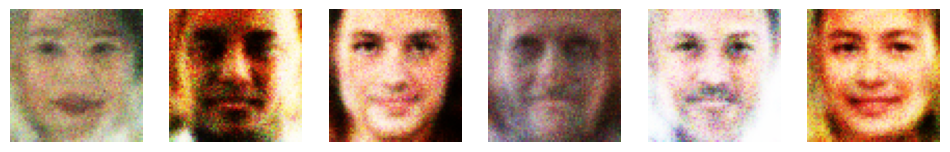

In [ ]:
G.load_state_dict(torch.load("checkpoints/generator_epoch_100.pth"))
G.eval()

noise = torch.randn(6, 100, device=device)
labels = torch.tensor([0, 1, 2, 3, 4, 5], device=device)

with torch.no_grad():
    imgs = G(noise, labels).cpu()
    imgs = (imgs + 1) / 2  # unnormalize
    fig, axes = plt.subplots(1, 6, figsize=(12, 2))
    for i in range(6):
        axes[i].imshow(imgs[i].permute(1, 2, 0))
        axes[i].axis('off')
    plt.show()
